In [2]:
import pandas as pd
import plotly.express as px


In [7]:
df = pd.read_csv("omni2_LyG9TzN27f.lst", delim_whitespace=True, header=None)
df.head()


C:\Users\nikhi\AppData\Local\Temp\ipykernel_7344\4214965401.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("omni2_LyG9TzN27f.lst", delim_whitespace=True, header=None)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2010,1,0,3.0,0.0,2.5,1.6,3.7,283.0,0.51,-0.45,2.81,0,5,4
1,2010,1,1,3.0,-0.7,2.2,1.6,3.8,280.0,0.52,-0.45,2.80,0,4,4
2,2010,1,2,3.0,-0.6,2.5,1.2,3.8,280.0,0.52,-0.34,2.74,0,4,4
3,2010,1,3,3.0,-0.4,2.6,1.0,3.8,281.0,0.60,-0.28,2.71,0,2,3
4,2010,1,4,2.9,-0.4,2.8,0.3,3.7,282.0,0.52,-0.08,2.81,0,0,3


In [8]:
df.columns = [
    'Year', 'Month', 'Day',
    'IMF_Mag', 'Bz_GSM', 'Density', 'Pressure', 'Speed',
    'Ey', 'Bx_GSM', 'By_GSM', 'Bz_GSM2', 'Dummy',
    'Kp1', 'Kp2'
]

In [ ]:
df = df[(df['Day'] >= 1) & (df['Day'] <= 31)]
df = df[(df['Month'] >= 1) & (df['Month'] <= 12)]

df.drop(columns=['Dummy', 'Bz_GSM2'], inplace=True)

In [10]:
df['Datetime'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-' +
    df['Day'].astype(str).str.zfill(2),
    format='%Y-%m-%d'
)
df.set_index('Datetime', inplace=True)

In [11]:
# Calculate Kp and target
df['Kp'] = (df['Kp1'] + df['Kp2']) / 2.0
df['Storm'] = (df['Kp'] >= 5).astype(int)

In [ ]:
df.replace([999.9, 999.99, 9999.9, 99999.9], pd.NA, inplace=True)
df.dropna(inplace=True)


In [13]:
df.head()

,Year,Month,Day,IMF_Mag,Bz_GSM,Density,Pressure,Speed,Ey,Bx_GSM,By_GSM,Kp1,Kp2,Kp,Storm
Datetime,,,,,,,,,,,,,,,
2010-01-01,2010,1,1,3.0,-0.7,2.2,1.6,3.8,280.0,0.52,-0.45,4,4,4.0,0
2010-01-02,2010,1,2,3.0,-0.6,2.5,1.2,3.8,280.0,0.52,-0.34,4,4,4.0,0
2010-01-03,2010,1,3,3.0,-0.4,2.6,1.0,3.8,281.0,0.60,-0.28,2,3,2.5,0
2010-01-04,2010,1,4,2.9,-0.4,2.8,0.3,3.7,282.0,0.52,-0.08,0,3,1.5,0
2010-01-05,2010,1,5,3.0,-0.2,2.5,1.3,3.5,280.0,0.47,-0.36,0,5,2.5,0


In [14]:
features = ['IMF_Mag', 'Density', 'Pressure', 'Speed', 'Bz_GSM']
target_cols = ['Speed', 'Bz_GSM']


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)


In [16]:
import numpy as np

def create_sequences(data, target_cols, input_window=24, forecast_horizon=6):
    X, y = [], []
    for i in range(len(data) - input_window - forecast_horizon + 1):
        x_i = data.iloc[i:i+input_window].values
        y_i = data[target_cols].iloc[i+input_window:i+input_window+forecast_horizon].values
        X.append(x_i)
        y.append(y_i)
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(df_scaled, target_cols, input_window=24, forecast_horizon=6)


In [ ]:
from sklearn.model_selection import train_test_split

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

n_features = X.shape[2]   # number of features (columns)
n_outputs = y.shape[1]    # forecast_horizon
n_targets = y.shape[2]    

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], n_features), return_sequences=False),
    Dense(n_outputs * n_targets),
    tf.keras.layers.Reshape((n_outputs, n_targets))  # reshape output to match (forecast_horizon, target features)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


c:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,700 (73.05 KB)

 Trainable params: 18,700 (73.05 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0433 - mae: 0.1419 - val_loss: 0.0162 - val_mae: 0.0838
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0091 - mae: 0.0695 - val_loss: 0.0156 - val_mae: 0.0813
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0087 - mae: 0.0657 - val_loss: 0.0141 - val_mae: 0.0774
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0079 - mae: 0.0615 - val_loss: 0.0128 - val_mae: 0.0741
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0077 - mae: 0.0601 - val_loss: 0.0124 - val_mae: 0.0727
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0076 - mae: 0.0591 - val_loss: 0.0115 - val_mae: 0.0695
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0078 - mae: 0.0593 - val_loss: 0.0119 - val_mae: 0.0698
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0077 - mae: 0.0588 - val_loss: 0.0115 - val_mae: 0.0682
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.007

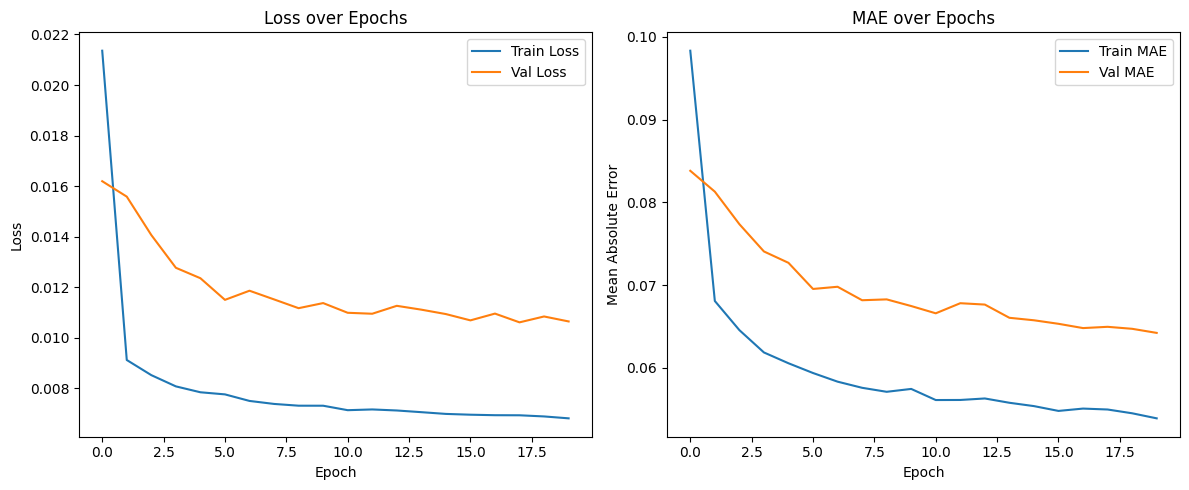

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

if 'mae' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


y_pred = model.predict(X_test)


y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()


rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae = mean_absolute_error(y_test_flat, y_pred_flat)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Test RMSE: 0.0751
Test MAE: 0.0523


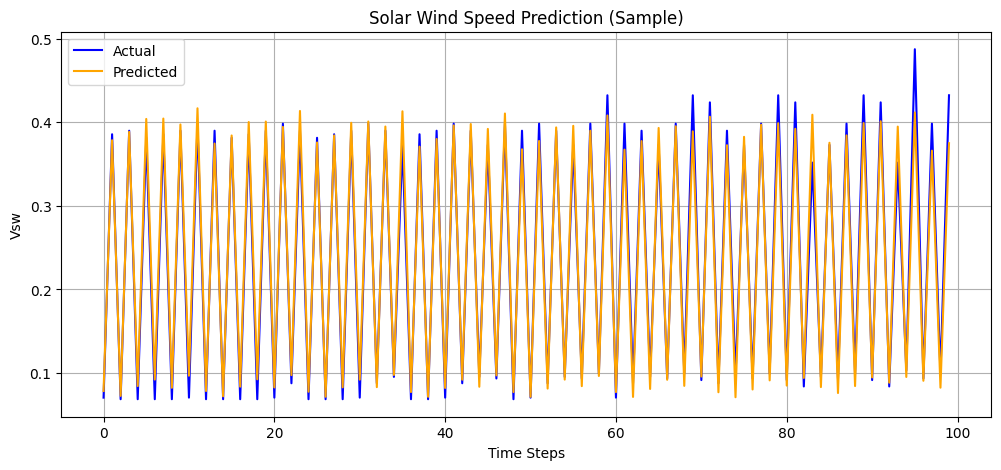

In [ ]:
import matplotlib.pyplot as plt

n = 100
plt.figure(figsize=(12, 5))
plt.plot(y_test_flat[:n], label='Actual', color='blue')
plt.plot(y_pred_flat[:n], label='Predicted', color='orange')
plt.title('Solar Wind Speed Prediction (Sample)')
plt.xlabel('Time Steps')
plt.ylabel('Vsw')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae = mean_absolute_error(y_test_flat, y_pred_flat)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")


RMSE: 0.0751, MAE: 0.0523


In [20]:
from tensorflow.keras.models import load_model
model = load_model('solar_wind_speed_model.h5')


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
import joblib


joblib.dump(model, 'solar_wind_model.pkl')




['solar_wind_model.pkl']